# 3D Rendering
* Raster drawing (2D)
* Projecting a point cloud
* Rotations
* Drawing a triangle
* Mesh representation
* left.obj

What we will not talk about: OpenGL conventions

## Raster drawing

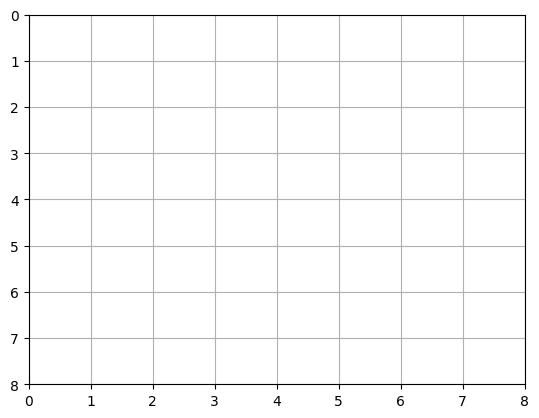

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True)); ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlim([0, 8])
ax.set_ylim([8, 0])
plt.grid()

In [3]:
import numpy as np

In [4]:
resolution = 320, 200
w, h = resolution
# Allocate a byte buffer. 0 = black, 255 = white
buffer = np.zeros((h, w, 1), dtype=np.uint8)

In [225]:
n = 512
np.random.seed(17)  # official KTH random number
pixels = 0.5 * np.array(resolution) + np.random.normal(size=(n, 2)) * 24
pixels

array([[166.63038136,  55.48892611],
       [174.97362667, 127.48747095],
       [184.89257124, 145.27933431],
       ...,
       [153.10858755,  79.91050367],
       [152.93358966,  95.34483545],
       [161.90449814,  97.83165585]])

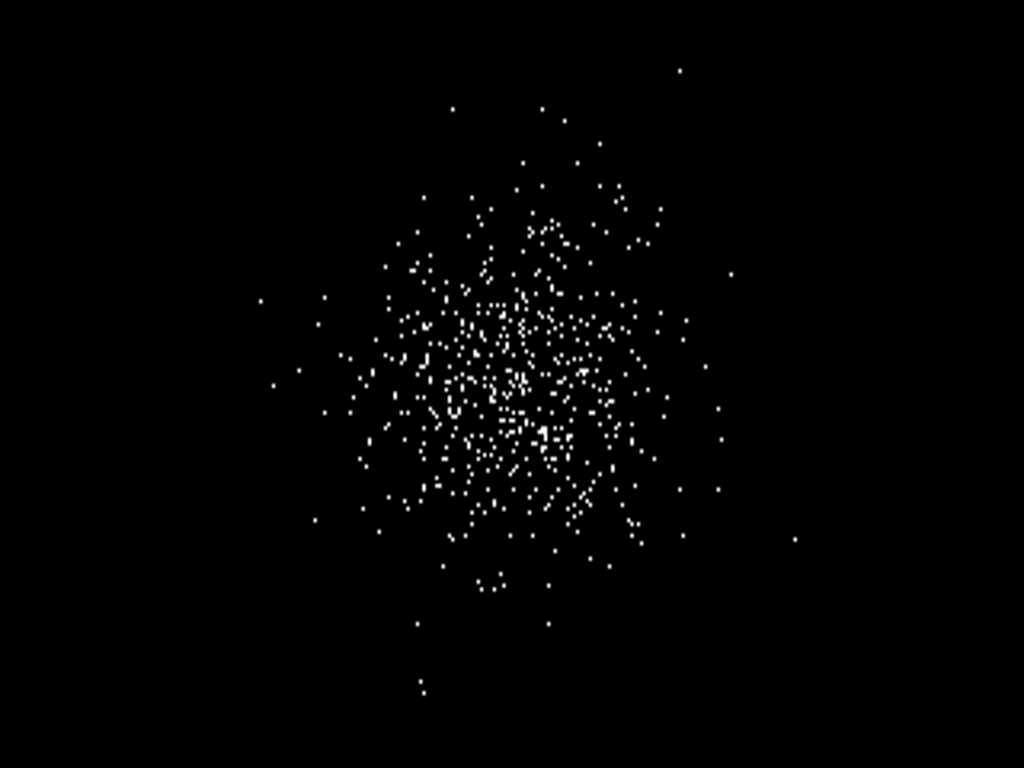

In [6]:
from typing import Tuple
from PIL import Image

def create_buffer(resolution: Tuple[int, int]):
    w, h = resolution
    return np.zeros((h, w, 3), dtype=np.uint8)

def draw_pixels(buffer: np.ndarray, pixels: np.ndarray) -> None:
    assert pixels.shape[1] == 2
    h, w, _ = buffer.shape
    for sx, sy in pixels.astype(int):
        if 0 < sx < w and 0 < sy < h:
            buffer[sy, sx] = 255, 255, 255

def show_buffer(buffer: np.ndarray) -> None:
    return Image.fromarray(buffer).resize((1024, 768))
    
buffer = create_buffer(resolution)
draw_pixels(buffer, pixels)
show_buffer(buffer)

## Projection

In [224]:
vertices = np.random.normal(size=(n, 3))
vertices

array([[ 1.45092469e-01, -1.12177499e+00,  4.75674694e-01],
       [-2.04786708e+00,  1.50623232e+00,  1.74524731e-03],
       [-9.37302784e-02,  3.93928506e-01,  2.78851753e-01],
       ...,
       [-8.94453722e-01, -3.64484551e-01, -5.53303227e-01],
       [-1.56059906e-01,  7.31876728e-02, -1.18489001e+00],
       [-1.19586592e+00, -9.52817512e-01,  9.11246911e-01]])

In [8]:
def orthographic(vertices: np.ndarray) -> np.ndarray:
    assert vertices.shape[1] == 3
    # just drop (ignore) z values
    return vertices[:, :2]  # first column means return all rows, :2 means return first two columns (but not the third which is z)

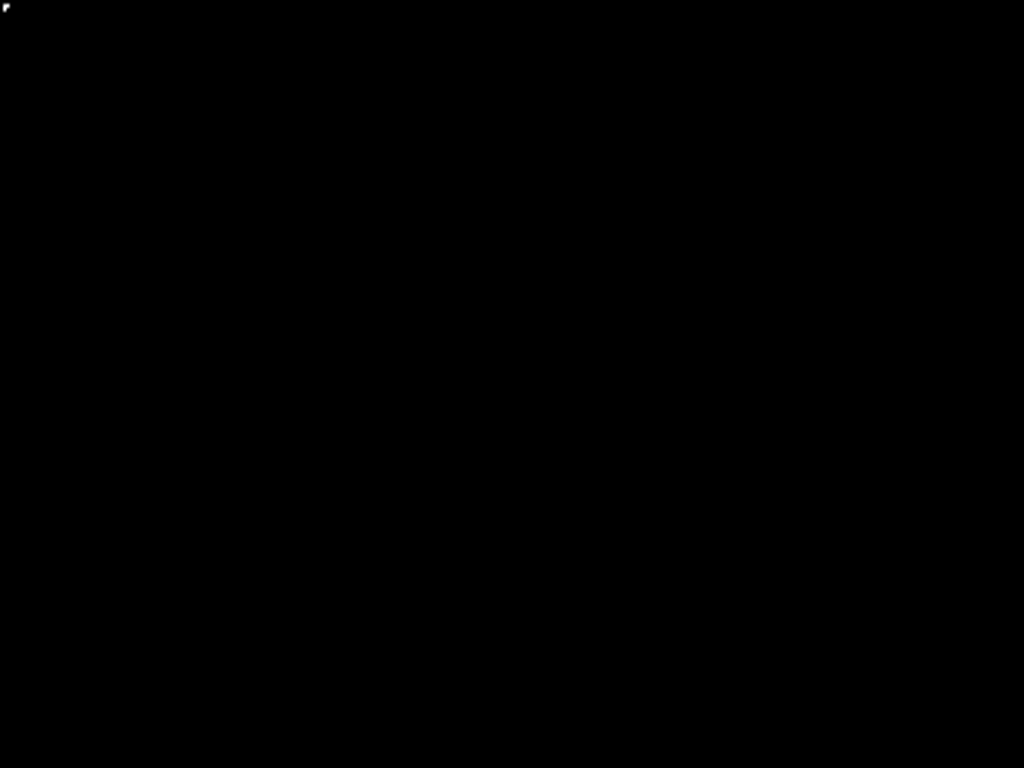

In [226]:
buffer = create_buffer(resolution)
draw_pixels(buffer, orthographic(vertices))
show_buffer(buffer)

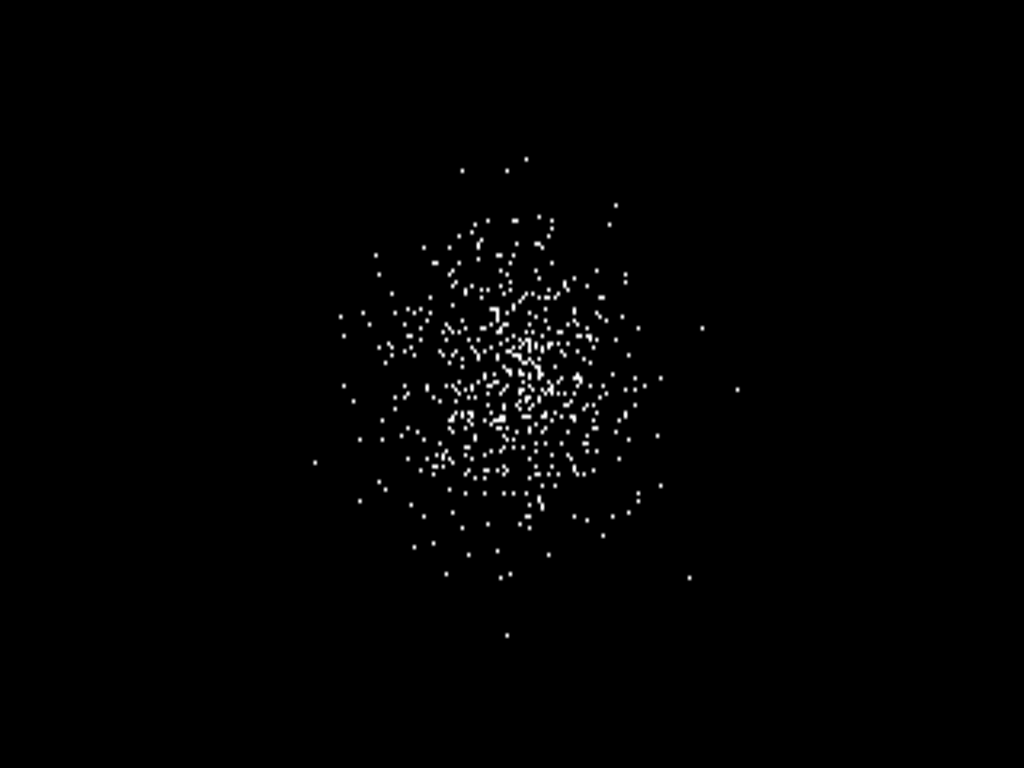

In [249]:
def to_screen(ndc: np.ndarray, resolution: Tuple[int, int]) -> np.ndarray:
    """Transforms pixels from the NDC cordinate system (-1 to 1) to the specificed resolution"""
    scale = np.min(resolution)
    return 0.5 * np.array(resolution) + scale * ndc

vertices = np.random.normal(size=(n, 3)) * 0.1  # smaller point cloud so it fits within the resolution
buffer = create_buffer(resolution)
draw_pixels(buffer, to_screen(orthographic(vertices), resolution))
show_buffer(buffer)

In [11]:
def transform(m: np.ndarray, points: np.ndarray) -> np.ndarray:
    """Transforms all points in `points` according to the transformation matrix `m`"""
    assert points.shape[1] == 3
    return (np.dot(m, points.T)).T

### Rotation matrix
$$\mathbf{R}\mathbf{R}^T = \mathbf{R}^T\mathbf{R} = \mathbf{I}$$

In [284]:
from math import cos, sin, pi
tau = 2 * pi  # one revolution

def rotate_y(theta: float) -> np.ndarray:
    return np.array([
        [cos(theta), 0, -sin(theta)],
        [         0, 1,          0],
        [sin(theta), 0,  cos(theta)],
    ])

np.set_printoptions(suppress=True)
np.dot(rotate_y(theta=17), rotate_y(theta=17).T)  # verify rotation

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [286]:
transform(rotate_y(theta=17), vertices)

array([[ 0.0007967 ,  0.014092  ,  0.00180235],
       [-0.00124614,  0.014164  , -0.00449565],
       [ 0.00198147,  0.016252  ,  0.00607633],
       ...,
       [ 0.13682219,  0.091643  , -0.04106465],
       [ 0.13688108,  0.091654  , -0.04085891],
       [ 0.12863746,  0.053052  , -0.06966142]])

In [287]:
# Some iphython stuff to display gifs
from typing import List
import IPython.display

def display_gif(frames: List[np.ndarray], framerate: float, **kwargs) -> IPython.display.Image:
    path = 'tmp.gif'
    images = [Image.fromarray(frame) for frame in frames]
    images[0].save(path, save_all=True, append_images=images[1:], duration=framerate * len(images), loop=0)
    return IPython.display.Image(url=path, **kwargs)

In [233]:
from typing import Callable

def point_cloud_frame(vertices: np.ndarray, project: Callable[[np.ndarray], np.ndarray]) -> np.ndarray:
    buffer = np.zeros((h, w, 3), dtype=np.uint8)  # create new frame
    ndc = project(vertices)  # project vertices into ndc
    pixels = to_screen(ndc, resolution)  # convert to screen space (resolution of buffer)
    draw_pixels(buffer, pixels)  # draw pixels
    return buffer

#vertices = np.random.uniform(-1, 1, size=(n, 3)) * 0.1
#vertices = np.random.normal(size=(n, 3)) * 0.1

thetas = np.linspace(0, tau, 200)
frames = [point_cloud_frame(transform(rotate_y(theta), vertices), project=orthographic) for theta in thetas]
display_gif(frames, framerate=1/30, width=1024)

## Perspective
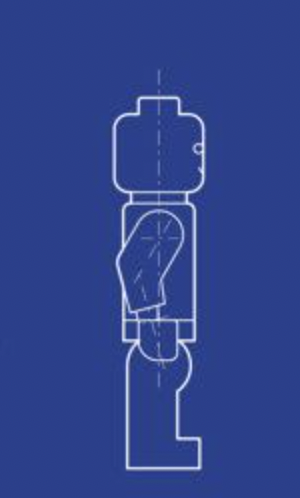

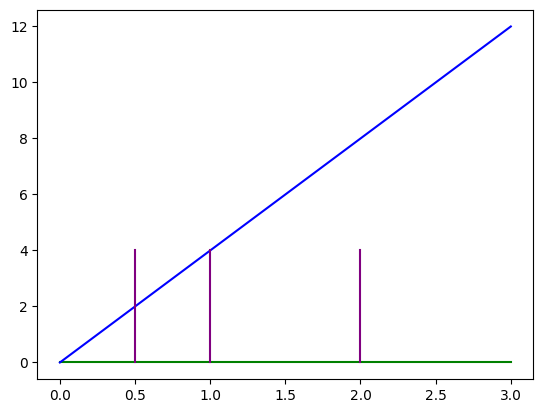

In [15]:
plt.plot([0, 3], [0, 0], 'green')  # ground
plt.plot([0, 3], [0, 12], 'blue')  # line of sight
plt.plot([1, 1], [0, 4], 'purple')  # minifig at z=1
plt.plot([2, 2], [0, 4], 'purple')  # minifig at z=2
plt.plot([0.5, 0.5], [0, 4], 'purple')  # minifig at z=0.5

Apparent height $y = h / z$

In [16]:
def perspective(vertices: np.ndarray) -> np.ndarray:
    z = vertices[:, 2][:, np.newaxis]  # all z-values
    return vertices[:, :2] / z  # pick x and y values and divide each row (vertex) with the corresponding z-value

In [17]:
transforms = (rotate_y(theta) for theta in np.linspace(0, tau, 200))
frames = [draw_frame(transform, vertices, project=perspective) for transform in transforms]
display_gif(frames, framerate=1/30, width=512)

In [262]:
# updated function with a translation parameter t
def draw_frame(m: np.ndarray, t: np.ndarray, vertices: np.ndarray, project: Callable[[np.ndarray], np.ndarray]) -> np.ndarray:
    buffer = np.zeros((h, w, 3), dtype=np.uint8)  # create new frame
    transformed = transform(m, vertices) + t # transform vertices
    ndc = project(transformed)  # project vertices into ndc
    pixels = to_screen(ndc, resolution)  # convert to screen space (resolution of buffer)
    draw_pixels(buffer, pixels)  # draw pixels
    return buffer

In [263]:
t = np.array([0, 0, 0.5])
transforms = (rotate_y(theta) for theta in np.linspace(0, tau, 200))
frames = [draw_frame(transform, t, vertices, project=perspective) for transform in transforms]
display_gif(frames, framerate=1/30, width=512)

## Triangles

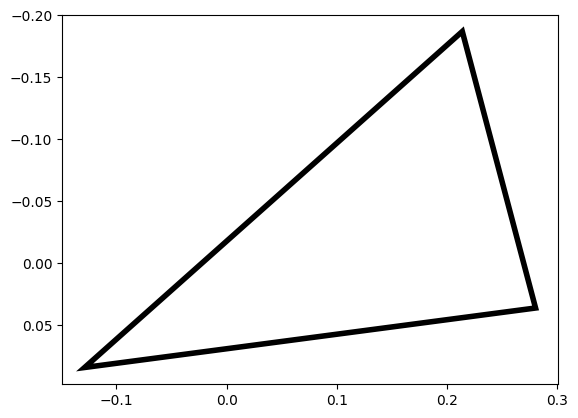

In [129]:
triangle = (0, 1, 2)  # pick the first three vertices to work with
plt.fill(vertices[triangle, 0], vertices[triangle, 1], fill=False, lw=4)
plt.gca().invert_yaxis()

## Barycentric cordinates

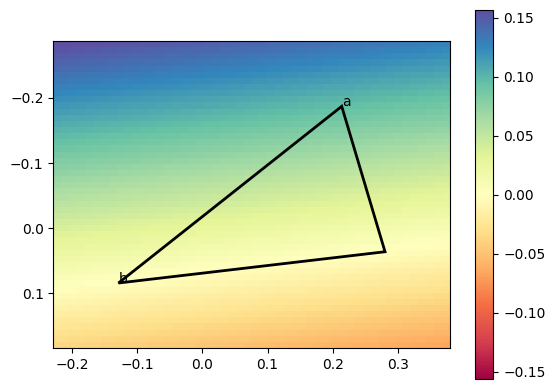

In [139]:
# barycentric cordinates
def edge(p0: np.ndarray, p1: np.ndarray, p: np.ndarray) -> float:
    """Computes the edge function at point p for the edge p0 -> p1. Arguments are either (1, 2) arrays or
    (n, 2) arrays. Broadcasting rules apply."""
    assert all(a.shape[1] == 2 for a in (p0, p1, p))  # all arrays must have two columns
    return (p[:, 0] - p0[:, 0]) * (p1[:, 1] - p0[:, 1])  - (p[:, 1] - p0[:, 1]) * (p1[:, 0] - p0[:, 0])

# get the three points of the triangle
a, b, c = np.vsplit(vertices[triangle, :2], 3)

# check if the triangle is inside-out, if so rearrange vertices
area = edge(a, b, c)
if area < 0:
    # pick new triangle
    triangle = (0, 2, 1)
    a, b, c = np.vsplit(vertices[triangle, :2], 3)

# find the bounding box, with some padding
padding = 0.1
xmin, ymin, _ = np.min(vertices[triangle, :], axis=0) - padding
xmax, ymax, _ = np.max(vertices[triangle, :], axis=0) + padding
#xmin, xmax = np.min(vertices[triangle, 0]) - padding, np.max(vertices[triangle, 0]) + padding
#ymin, ymax = np.min(vertices[triangle, 1]) - padding, np.max(vertices[triangle, 1]) + padding
X, Y = np.meshgrid(np.linspace(xmin, xmax), np.linspace(ymin, ymax))  # arrange a gridspace on the bounding box
p = np.vstack([X.ravel(), Y.ravel()]).T  # arrange all the points of the grid as a list of points

bc = edge(b, c, p)  # evaluate the edge-function a -> b for all the points p in the bounding box (p)
ef = bc  # plot ab

from matplotlib import colormaps
v = max(-np.min(ef), np.max(ef))
plt.imshow(
    ef.reshape(X.shape),
    extent=(xmin, xmax, ymax, ymin),
    cmap=colormaps['Spectral'],  # divergent colormap to highlight the 0 line
    vmin=-v, vmax=v,  # center colormap on 0
)
plt.fill(vertices[triangle, 0], vertices[triangle, 1], fill=False, lw=2)
plt.gca().annotate('a', a.ravel()); plt.gca().annotate('b', b.ravel())
plt.colorbar()

In [142]:
%load_ext Cython

In [236]:
%%cython
import cython
import numpy as np
cimport numpy as cnp

cdef const double edgef(
    const double p0x, const double p0y,
    const double p1x, const double p1y,
    const double x, const double y,
):
    return (x - p0x) * (p1y - p0y) - (y - p0y) * (p1x - p0x)


@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def draw_triangle(cnp.ndarray[cnp.uint8_t, ndim=3] buffer: np.ndarray, corners: np.ndarray, color: int=255):
    # unpack cordinates
    (ax, ay), (bx, by), (cx, cy) = corners
    # check for inverted triangles
    if edgef(ax, ay, bx, by, cx, cy) < 0:
        return
    # find the bounding box
    cdef int xmin, ymin, xmax, ymax
    xmin, ymin = np.min(corners, axis=0).astype(int)
    xmax, ymax = np.max(corners, axis=0).astype(int) + 1
    # clip
    xmin, xmax = max(xmin, 0), min(xmax, 320)
    ymin, ymax = max(ymin, 0), min(ymax, 200)

    cdef int x, y
    cdef double ab, bc, ca
    for y in range(ymin, ymax):
        for x in range(xmin, xmax):
            # compute edge functions
            ab = edgef(ax, ay, bx, by, x, y)
            bc = edgef(bx, by, cx, cy, x, y)
            ca = edgef(cx, cy, ax, ay, x, y)
            if ab >= 0 and bc >= 0 and ca >= 0:
                buffer[y, x] = color

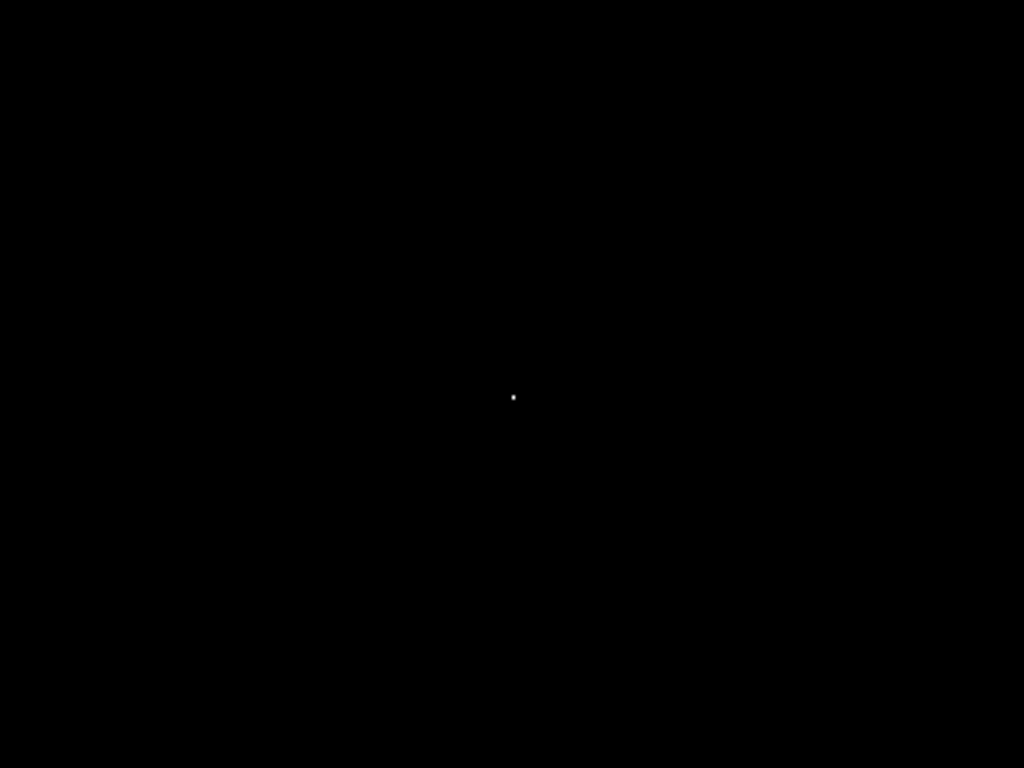

In [206]:
buffer = np.zeros((h, w, 3), dtype=np.uint8)  # create new frame
screen = to_screen(orthographic(vertices[triangle, :]), resolution)
draw_triangle(buffer, screen)
show_buffer(buffer)

# Mesh representation
Meshes, in its basic form, consists of a set of faces. For storage and manipulation vertices are normally _de-duplicated_, while for rendering vertices are normally _duplicated_ as it increase rendering speed.

In the de-duplicated format you have a vertex list and a face list. Normally only triangles are considered.

In [23]:
from typing import TextIO

def load_obj(f: TextIO) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Load object file and return mesh
    Args:
        f: open OBJ file to load.
    Returns:
        vertices: Mesh vertices.
        normals: Surface normals.
        faces: List of triangles.
    """
    vertices = []
    normals = []
    faces = []
    vertex_normals = []
    texture_coords = []
    for line in f:
        if line.startswith('#'):
            continue
        values = line.split()
        if not values:
            continue
        if values[0] == 'v':
            vertices.append(list(map(float, values[1:4])))
        elif values[0] == 'vn':
            normals.append(list(map(float, values[1:4])))
        elif values[0] == 'vt':
            continue
        elif values[0] == 'f':
            face_chunks = []
            for v in values[1:]:
                p = v.split('/')
                face_chunks.append(int(p[0]))
                # Format: v1/vt1
                if len(p) >= 2 and p[1]:
                    texture_coords.append(int(p[1]))
                # Format: v1/vt1/vn1 or v1//vn1
                if len(p) >= 3 and p[2]:
                    vertex_normals.append(int(p[2]))
            faces.append(face_chunks)

    # Return as numpy arrays and make faces 0-based, obj is 1-based.
    return np.asarray(vertices), np.asarray(faces, dtype=int) - 1, np.asarray(normals)

In [265]:
with open('left.obj') as f:  # samuels foot
    vertices, triangles, normals = load_obj(f)

print('vertices:', len(vertices), 'triangles:', len(triangles))
print(vertices)
print(triangles)

vertices: 2553 triangles: 5102
[[-1.9520e-03  1.4092e-02  2.7000e-04]
 [ 4.6650e-03  1.4164e-02  3.9000e-05]
 [-6.3870e-03  1.6252e-02  2.3300e-04]
 ...
 [ 1.8310e-03  9.1643e-02  1.4284e-01]
 [ 1.6170e-03  9.1654e-02  1.4284e-01]
 [ 3.1576e-02  5.3052e-02  1.4284e-01]]
[[  84   26   88]
 [  29   90   88]
 [  26   29   88]
 ...
 [2498 2518 2489]
 [2489 2552 2462]
 [2489 2462 2498]]


In [266]:
# same code as before, just different vertices
t = np.array([0, -0.1, 0.4])
transforms = (rotate_y(theta) for theta in np.linspace(0, tau, 200))
frames = [draw_frame(transform, t, vertices, project=perspective) for transform in transforms]
display_gif(frames, framerate=1/30, width=512)

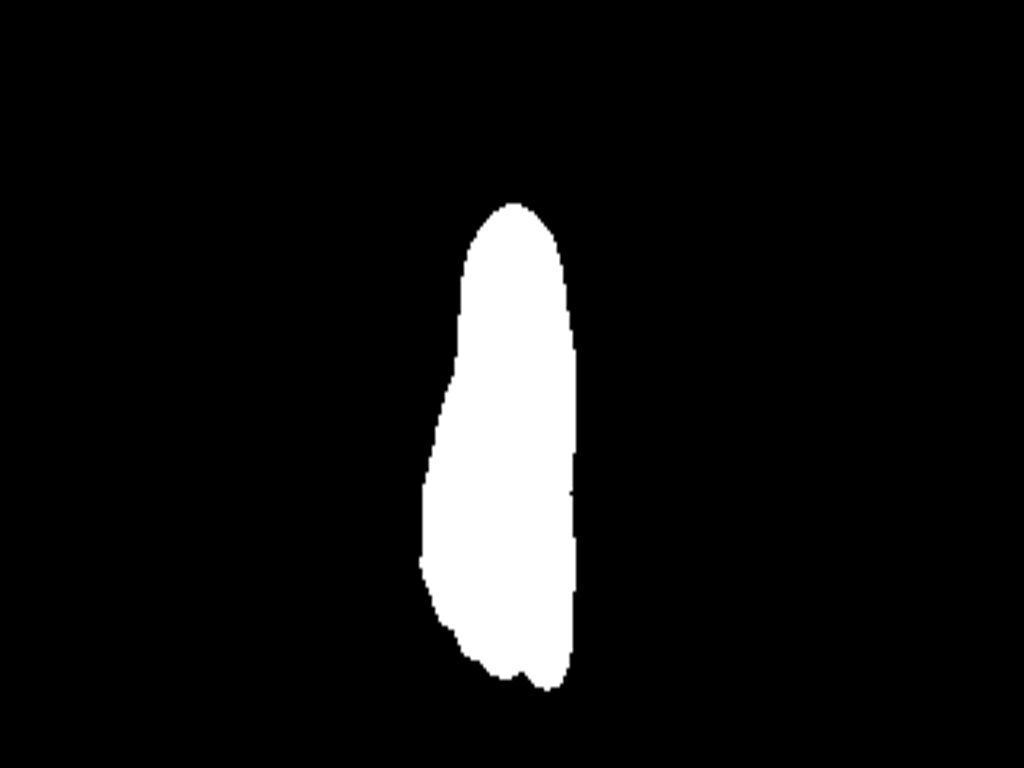

In [267]:
def draw_mesh(buffer: np.ndarray, vertices: np.ndarray, triangles: np.ndarray):
    screen = to_screen(perspective(vertices), resolution)
    for triangle in triangles:
        draw_triangle(buffer, screen[triangle])

buffer = np.zeros((h, w, 3), dtype=np.uint8)  # create new frame
draw_mesh(buffer, vertices + t, triangles)
show_buffer(buffer)

In [280]:
def draw_mesh(buffer, resolution, vertices, triangles):
    screen = to_screen(perspective(vertices), resolution)
    minz, maxz = np.min(vertices[:, 2]), np.max(vertices[:, 2])
    for triangle in triangles:
        mean_z = np.mean(vertices[triangle, 2], axis=0)
        intensity = 1.0 - (mean_z - minz) / (maxz - minz)
        draw_triangle(buffer, screen[triangle], color=int(255 * intensity))

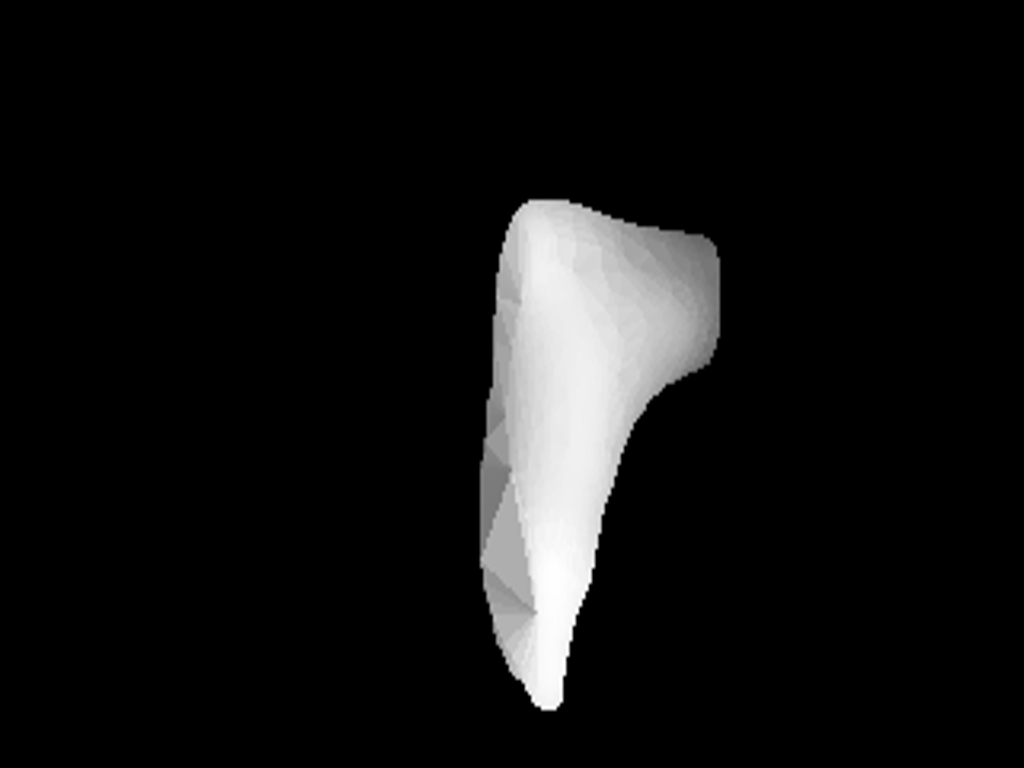

In [281]:
t = np.array([0, -0.1, 0.4])
buffer = np.zeros((h, w, 3), dtype=np.uint8)  # create new frame
draw_mesh(buffer, resolution, transform(rotate_y(theta=-1.1), vertices) + t, triangles)
show_buffer(buffer)

In [282]:
%%time
def draw_frame(vertices, triangles):
    buffer = np.zeros((h, w, 3), dtype=np.uint8)  # create new frame
    draw_mesh(buffer, resolution, vertices, triangles)
    return buffer

t = np.array([0, -0.1, 0.4])
thetas = np.linspace(0, tau, 100)

frames = [draw_frame(transform(rotate_y(theta), vertices) + t, triangles) for theta in thetas]
display_gif(frames, framerate=1/30, width=512)

CPU times: user 4.11 s, sys: 18.7 ms, total: 4.13 s
Wall time: 4.14 s


## Quizz time!
The edge function...
* Computes a function at the compute edge, similar to a cloud function
* Is one permutation of the three edges of the triangle
* Computes the signed distance to the line of an edge